# Tumor Detection Project


### Libraries & Frameworks Initialization

This project builds a deep learning system to detect tumors in medical images. It uses TensorFlow/Keras for model building, NumPy for data processing, and Matplotlib for visualization. Key features include modular model design, optimization with Adam/RMSprop, binary cross-entropy loss, and training enhancements like EarlyStopping and ReduceLROnPlateau.

In [28]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import shutil

from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers



### Files Handling

This section handles splitting the dataset into training, testing, and validation sets and organizes images into labeled folders (yes/no) for supervised learning.

In [29]:
img_path='images/brain_tumor_dataset'

In [30]:
test='images/test'
train='images/train'
validation='images/validation'
for folders in os.listdir(img_path):
    folder=os.path.join(img_path,folders)
    img_len=len(os.listdir(folder))
    for (n,file_name) in enumerate(os.listdir(folder)):
        img=os.path.join(folder,file_name)
        if n<10:
            shutil.copy(img,test)
        if 10<n<0.8*img_len:
            shutil.copy(img,train)
        else:
            shutil.copy(img,validation)

In [32]:
files = [train, validation, test]

for file in files:
    yes_folder = os.path.join(file, 'yes')
    no_folder = os.path.join(file, 'no')

    # Create folders if they don't exist
    os.makedirs(yes_folder, exist_ok=True)
    os.makedirs(no_folder, exist_ok=True)

    for img in os.listdir(file):
        if img.endswith(('.jpg', '.JPG', '.jpeg', '.PNG', '.png', '.JPEG')):
            img_loc = os.path.join(file, img)

            if 'yes' in img.lower() or 'y' in img.lower():
                shutil.move(img_loc, yes_folder)
            elif 'no' in img.lower() or 'n' in img.lower():
                shutil.move(img_loc, no_folder)


### DATASETS

This section loads images from the organized folders into TensorFlow datasets for training, validation, and testing. Images are resized, batched, labeled automatically (yes/no), and shuffled to prepare for model training.

In [33]:
image_size=(224,224)
batch_size=32

train_ds=tf.keras.utils.image_dataset_from_directory('images/train'
                                                    ,image_size=image_size
                                                    ,batch_size=batch_size,
                                                    labels='inferred',
                                                    label_mode='binary',
                                                    shuffle=True,
                                                    seed=123
                                                    )

Found 181 files belonging to 2 classes.


In [34]:
val_ds=tf.keras.utils.image_dataset_from_directory('images/validation'
                                                  ,image_size=image_size
                                                  ,batch_size=batch_size,
                                                  labels='inferred'
                                                  ,label_mode='binary'
                                                  ,shuffle=True,
                                                  seed=123
                                                  )

Found 72 files belonging to 2 classes.


In [35]:
test_ds=tf.keras.utils.image_dataset_from_directory('images/test',
                                                   image_size=image_size,
                                                   batch_size=batch_size,
                                                   labels='inferred',
                                                   label_mode='binary',
                                                   shuffle=False,
                                                   seed=123
                                                   )

Found 20 files belonging to 2 classes.


### Augmentation, Normalization and Prefetching

This section applies real-time data augmentation (flipping, zooming, rotation, translation, contrast adjustment) to increase dataset diversity and improve model generalization. It also normalizes pixel values and optimizes dataset performance using caching and prefetching for efficient training.

In [36]:

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.05, 0.08),
     layers.RandomContrast(0.3)
])



In [37]:
normalization_layer=tf.keras.layers.Rescaling(1./255)

In [38]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Following is an alternative of applying the  Augmentation, Normalization and Prefetching to datasets

In [51]:
# train_ds=train_ds.map(lambda x,y:(data_aug(normalization_layer(x)),y))
# val_ds=val_ds.map(lambda x,y:(normalization_layer(x),y))
# test_ds=test_ds.map(lambda x,y:(normalization_layer(x),y))

In [52]:
# train_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
# val_ds=val_ds.map(lambda x,y:(normalization_layer(x),y))
# test_ds=test_ds.map(lambda x,y:(normalization_layer(x),y))

# CNN Model

This section defines the CNN model for tumor detection. It includes:  
     -- Input layer with data augmentation and normalization.  
     -- Multiple convolutional layers with ReLU activation and L2 regularization to extract features.  
     -- MaxPooling layers for spatial downsampling.  
     -- Dense layers with Dropout for classification and overfitting prevention.  
     -- Output layer with sigmoid activation for binary classification (tumor: yes/no).

In [39]:
model=tf.keras.Sequential([
    
    Input(shape=(224, 224, 3)), 
    data_aug,
    normalization_layer,
    layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(1e-5)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(1e-5)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),

    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1,activation='sigmoid')

])



## Compile

The model is compiled using the Adam optimizer with a learning rate of 0.0003. It uses binary crossentropy as the loss function for tumor classification and tracks accuracy as the evaluation metric.


In [40]:
model.compile(optimizer=Adam(learning_rate=3e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Callbacks[LROn, Early|Stopping]

The model is trained for up to 40 epochs using the training dataset, with validation on the validation set.  

- **ReduceLROnPlateau**: Monitors validation loss and reduces the learning rate by half if no improvement is seen for 3 epochs, with a minimum learning rate of 1e-7.  
- **EarlyStopping**: Stops training if validation loss does not improve for 10 consecutive epochs and restores the best model weights.  

This setup helps in faster convergence and prevents overfitting.

In [42]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7,
    mode='min'
    
)
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[reduce_lr,early_stop]
)

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 914ms/step - accuracy: 0.5746 - loss: 0.8269 - val_accuracy: 0.7500 - val_loss: 0.6187 - learning_rate: 3.0000e-04
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step - accuracy: 0.6354 - loss: 0.6403 - val_accuracy: 0.5972 - val_loss: 0.6091 - learning_rate: 3.0000e-04
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 772ms/step - accuracy: 0.6575 - loss: 0.6186 - val_accuracy: 0.7500 - val_loss: 0.6043 - learning_rate: 3.0000e-04
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step - accuracy: 0.7072 - loss: 0.6002 - val_accuracy: 0.7361 - val_loss: 0.5732 - learning_rate: 3.0000e-04
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 738ms/step - accuracy: 0.6906 - loss: 0.5961 - val_accuracy: 0.7778 - val_loss: 0.5437 - learning_rate: 3.0000e-04
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 747ms/step - accuracy: 0.6851 - loss: 0.5871 - val_accuracy: 0.7500 - val_loss: 0.5193 - learning_rate: 3.0000e-04
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 727ms/step - accuracy: 0.7182 - loss:

## Evaluate the Model On the test set:



The trained model is evaluated on the test dataset to measure its performance on unseen data.  

- **Test Accuracy**: Shows how well the model predicts tumor presence in new images.  
- **Test Loss**: Measures the error between predicted and actual labels on the test set.  


In [43]:
test_loss,test_accuracy=model.evaluate(test_ds)
print(f'Test Accuracy:{test_accuracy:.4f}')
print(f'Test loss:{test_loss:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8000 - loss: 0.4459
Test Accuracy:0.8000
Test loss:0.4459


### Visualizing Predictions from the Test Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Index got Wrong: 1
Index got Wrong: 6
Index got Wrong: 12
Index got Wrong: 19


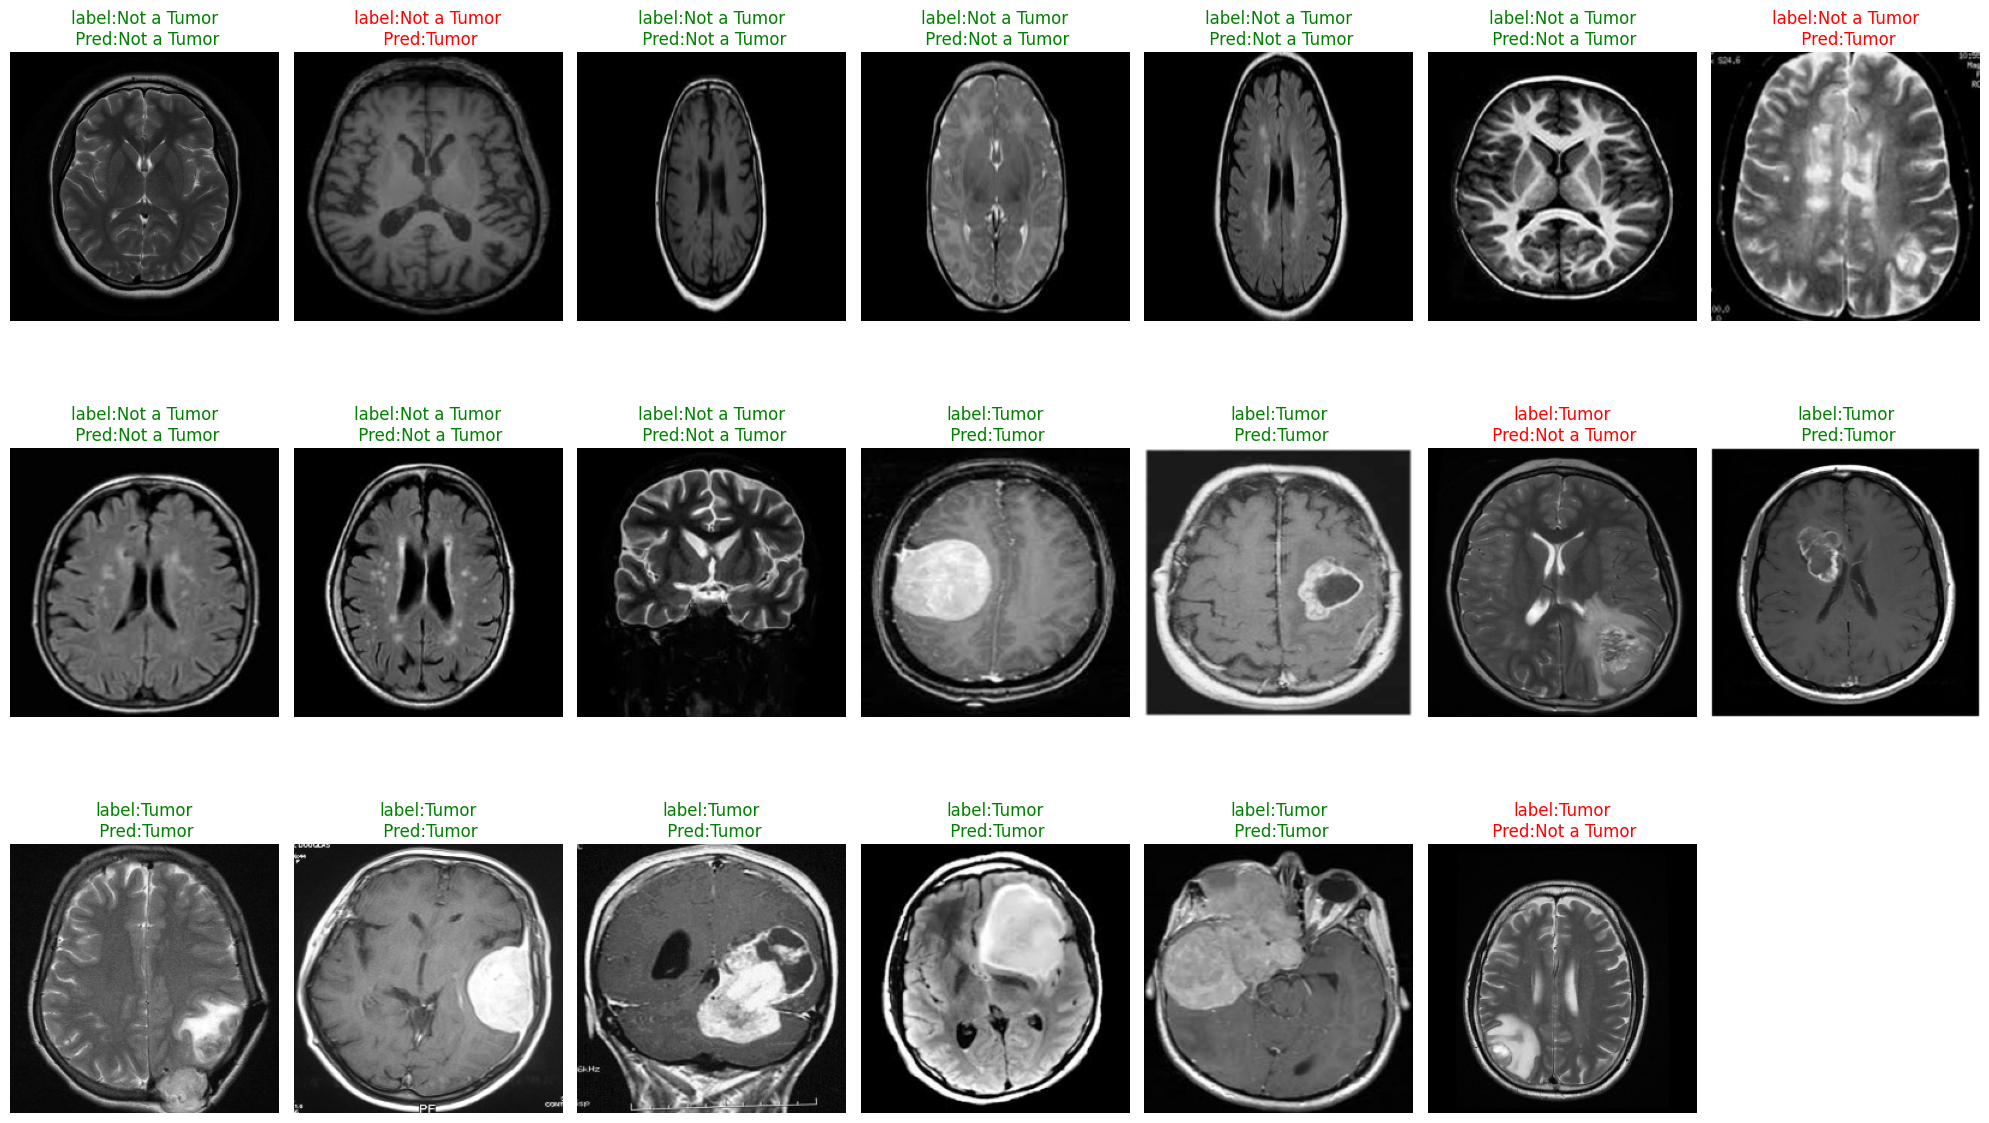

In [44]:
def plot_predictions(model, ds):
    class_name=['Not a Tumor','Tumor']
    for images,labels in ds.take(9):
        # print(images)
        pred=model.predict(images)
        preds=tf.squeeze(tf.round(pred)).numpy()
        preds=preds.astype(int)
        # print(preds[10])
        label=tf.squeeze(tf.round(labels)).numpy()
        label=label.astype(int)
    
        
#create a canva
        plt.figure(figsize=(20,20))
#accessing img 
        for i in range(len(images)):
            #subplot and mentioning the location of the subplot with perticular grids
            ax=plt.subplot(5,7,i+1)
            img=images[i]/255
            # img=images[i]
            plt.imshow(img)
            title= f'label:{class_name[(label[i])]}\n Pred:{class_name[(preds[i])]}'
            color='green' if (preds[i]==label[i]) else 'red'
            if preds[i]!=label[i]: print("Index got Wrong:",i)
            plt.title(title,color=color)
            plt.axis('off')
    plt.tight_layout()
    plt.show()





plot_predictions(model, test_ds)

## Model Performance: Loss and Accuracy


**Training and Validation Accuracy Plot**:  

This plot visualizes how the model's accuracy evolves over epochs during training.

- **X-axis**: Epochs  
- **Y-axis**: Accuracy  
- **Lines**:  
  - **Train Accuracy**: Accuracy on the training dataset.  
  - **Validation Accuracy**: Accuracy on the validation dataset.  

It helps to identify overfitting, underfitting, and overall learning progress.


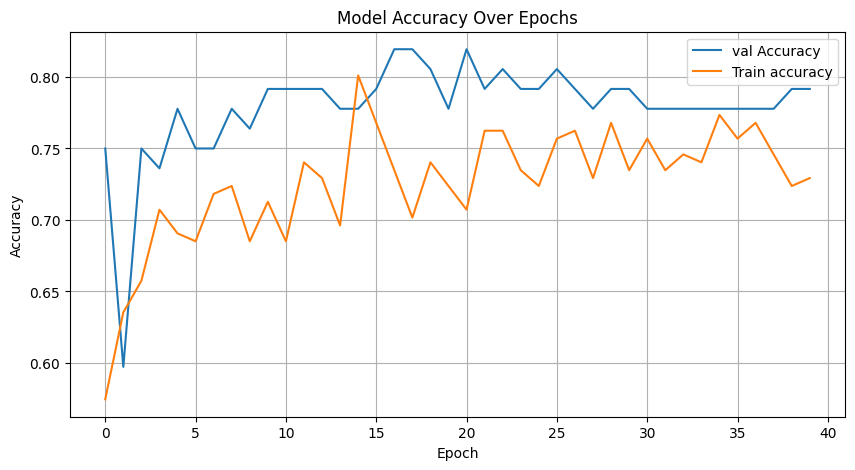

In [45]:
plt.figure(figsize=(10,5))
plt.plot(history.history['val_accuracy'],label='val Accuracy')
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Training and Validation Loss Plot**:  

his plot shows the model's loss progression over epochs, helping to monitor convergence and overfitting.

- **X-axis**: Epochs  
- **Y-axis**: Loss  
- **Lines**:  
  - **Train Loss**: Loss on the training dataset.  
  - **Validation Loss**: Loss on the validation dataset.  

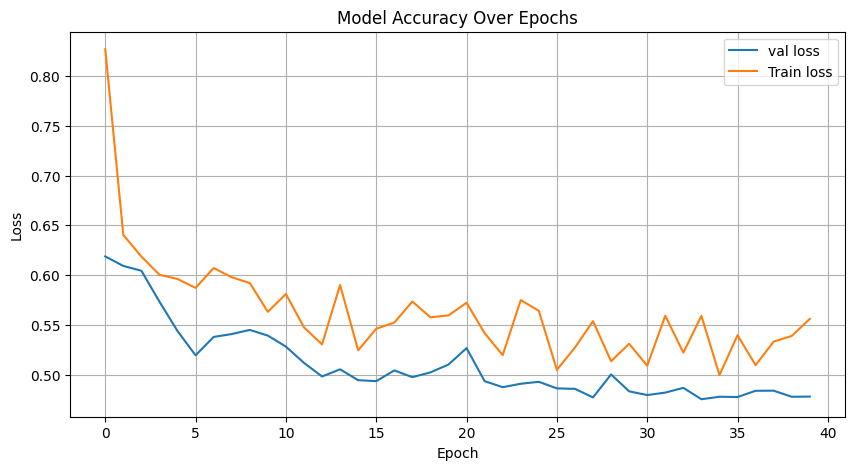

In [46]:
plt.figure(figsize=(10,5))
plt.plot(history.history['val_loss'],label='val loss')
plt.plot(history.history['loss'],label='Train loss')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()